## Flat internal organization from the footprint
Model takes a footprint of a flat with marked entrance and windows and generates the internal organization of it.

In [81]:
import torch 
from torch import nn 
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
import numpy as np

import matplotlib.pyplot as plt

import wandb

In [30]:
# constants
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

data_root = './data/'

batch_size = 64
num_workers = 8

In [31]:
# data
mnist_transforms = transforms.ToTensor()

dataset = datasets.MNIST(data_root, transform=mnist_transforms, download=True)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [43]:
# define a model
class AwesoneAE(pl.LightningModule):
    def __init__(self, embedding_len: int = 10):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 64),
            nn.ReLU(),
            nn.Linear(64, embedding_len)
        )
        self.decoder = nn.Sequential(
            nn.Linear(embedding_len, 64),
            nn.ReLU(),
            nn.Linear(64, 28 * 28)
        )
        
    def forward(self, X):
        embedding = self.encoder(X)
        return X
    
    def training_step(self, batch, batch_idx):
        # training_step defined the train loop.
        # It is independent of forward
        x, y = batch
        x = x.reshape(x.shape[0], -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = F.mse_loss(x_hat, x)
        # Logging to TensorBoard by default
        self.log("train_loss", loss)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [44]:
model = AwesoneAE(10)

trainer = pl.Trainer(max_epochs=25)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [38]:
trainer.fit(model, dataloader)


  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 50.9 K
1 | decoder | Sequential | 51.7 K
---------------------------------------
102 K     Trainable params
0         Non-trainable params
102 K     Total params
0.410     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [45]:
autoencoder = AwesoneAE.load_from_checkpoint("/Users/saladartem/Documents/FIT/Masters/MVI/mvi-sp/lightning_logs/version_5/checkpoints/epoch=24-step=23449.ckpt")

In [77]:
encoder = autoencoder.encoder
encoder.eval()

img = np.zeros((28,28))
img[:, 18] = 1

img = img.reshape(1, 784)

code = encoder(torch.Tensor(img))

In [78]:
decoder = autoencoder.decoder
decoder.eval()

Sequential(
  (0): Linear(in_features=10, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=784, bias=True)
)

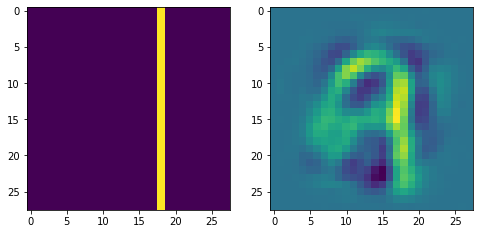

In [79]:
fig, ax = plt.subplots(1, 2, figsize=(8, 12))

ax[0].imshow(img.reshape(28, 28))
ax[1].imshow(decoder(code).reshape(28,28).detach().numpy())
plt.show()

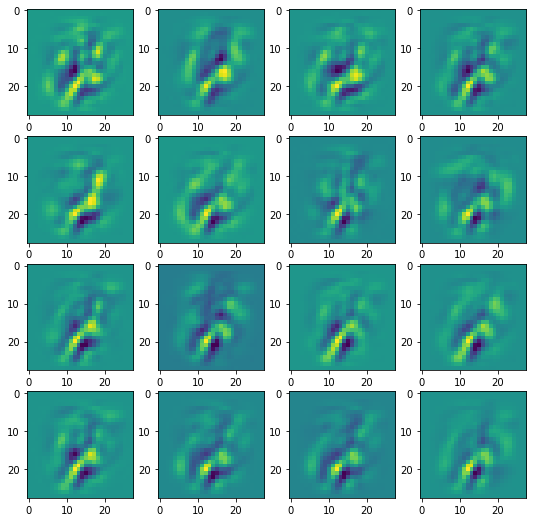

In [61]:
fig, axs = plt.subplots(4, 4, figsize=(9,9))
for i in range(16):
    axs[i // 4][i % 4].imshow(decoder(torch.rand(1, 10)).reshape(28,28).detach().numpy())
plt.show()